# QA Gen
a notebook that uses GroundX Parse to explore a document and generate question answer pairs.

The end result is a parallelized program which generates question/answer pairs in the background while rendering a simple html UI for human vetting in the front end. Accepted Q/A pairs are accumulated and returned in the final code block.

video: https://www.youtube.com/watch?v=fC6Jybh96Y4

In [2]:
"""Requires the following environment variables:
- GROUNDX_API_KEY
- OPENAI_API_KEY
in a .env file

Also, requires a document_id from uploading to GroundX. You can find a document
id by exploring the GroundX Dashboard.
"""

from dotenv import load_dotenv
load_dotenv()

"""A document uploaded to and stored on GroundX
"""
document_id = 'b33b825c-2b38-4631-908e-0a76479bf116'

In [16]:
!pip3 install groundx
!pip3 install -U openai
!pip3 install pandas

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 508 kB 21.2 MB/s eta 0:00:01
     |████████████████████████████████| 346 kB 21.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# Getting XRay Parse Data

Getting the GroundX Parse results, aka xRay.

In [8]:
from groundx import GroundX
import os
client = GroundX(
  api_key=os.getenv('GROUNDX_API_KEY'),
)

response = client.documents.get(
    document_id=document_id
)

import urllib.request, json
with urllib.request.urlopen(response.document.xray_url) as url:
    xRayData = json.load(url)

document_url = response.document.source_url

# Filtration
To make question answer pairs, we're only interested in chunks which have certain attributes. These could be modified depending on the use case.

Here, I don't want a bunch of chunks from a single page, so I'm filtering by that.

In [9]:
qa_generation_data = []

# Only allowing a certain number per page
max_per_page = 2  # Set your desired max per page
num_per_page = {}

for chunk in xRayData['chunks']:
    # Only using chunks where the content exists on a single page
    if len(chunk['pageNumbers']) != 1:
        continue

    # Only accepting chunks which have a single bounding box, for now
    if len(chunk['boundingBoxes']) != 1:
        pass

    # Get the page number for this chunk
    page_number = chunk['pageNumbers'][0]

    # Check if we've reached the max number of items for this page
    if num_per_page.get(page_number, 0) >= max_per_page:
        continue

    # Append data for generating QA pairs
    qa_generation_data.append({**chunk, 'documentUrl': document_url})

    # Increment the count for this page
    num_per_page[page_number] = num_per_page.get(page_number, 0) + 1

# Generating QA pairs from generation data

Generating a set of QA pairs. This code block defines the core prompt which informs the model of how to generate QA pairs. 5 QA pairs are hard coded to be easier on the LLM. These are what become a batch in future code blocks.

In [10]:
from openai import OpenAI
from pydantic import BaseModel, constr, Field
from typing import Dict

#defining client
client = OpenAI()

#defining base model for parsing
class QAModel(BaseModel):
    rationale: str
    question_1: str
    answer_1: str
    question_2: str
    answer_2: str
    question_3: str
    answer_3: str
    question_4: str
    answer_4: str
    question_5: str
    answer_5: str


def gen_qa_batch(gen_data):

    #creating context
    context = f'''Use the following data to generate question answer pairs:

{gen_data['suggestedText']}'''

    #querying the model
    response = client.beta.chat.completions.parse(
        model='gpt-4o-mini',
        messages=[
            {"role": "system", "content": '''You are tasked with turning data into
            a set of question answer pairs which will be used to test information
            extraction systems. it is your job to create a set of question and
            answer pairs which expore a wide range of topics and types of information

            first, look at the data and construct a "rationale". This rationale
            should include a breakdown of the types of information presented, and
            what an information extraction system might fail at when analyzing this
            type of data. Then, generate a batch of question-answer pairs
            that would adequetly test based on the rationale.

            Important considerations:
            - The question should be clear enough where a single answer can be found
            - There are tens if not hundreds of documents. Questions must be specific.
            - Avoid questions like "this figure", "in the section" and "in the document",
            as there are many documents.
            - The objective is to ask fair questions where a clear answer is obvious.'''
            },
            {"role": "user", "content": context},
        ],
        response_format=QAModel
    )

    #transforming the response into a more handy structure.
    data = dict(response.choices[0].message.parsed)

    transformed_data = {
        'rationale': data['rationale'],
        'questions_answers': [
            {'question': data[f'question_{i}'], 'answer': data[f'answer_{i}']}
            for i in range(1, 6)
        ]
    }

    #adding additional information that's important for rendering:
    result = {**transformed_data,
              'documentUrl':gen_data['documentUrl'],
              'pageNumbers':gen_data['pageNumbers'],
              'boundingBoxes':gen_data['boundingBoxes']}

    return result

gen_qa_batch(qa_generation_data[1])

{'rationale': "The data presents a structured table detailing defect descriptions and definitions relevant to a supply chain context, specifically related to Walmart's operational standards. Each row provides specific and tangible examples of defects that can occur, alongside succinct definitions that clarify what each defect entails. An information extraction system might struggle with nuances in the wording of the definitions or misinterpret the context surrounding terms like 'ASN' or 'PO' without adequate background. Additionally, variations in phrasing could lead to confusion in accurately matching defects to their definitions. It's crucial to create questions that directly reference specific defects, ensuring clarity and the ability to pinpoint exact definitions. Thus, questions need to test system understanding of both defect types and their precise meanings without ambiguity.",
 'questions_answers': [{'question': "What is the definition of the defect described as 'Overage'?",
  

# Creating a function for rendering
- Downloads from URL
- saves pdf locally for faster followup
- renders a page
- draws a boudning box on the page

In [12]:
!pip3 install pymupdf

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 18.6 MB 3.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


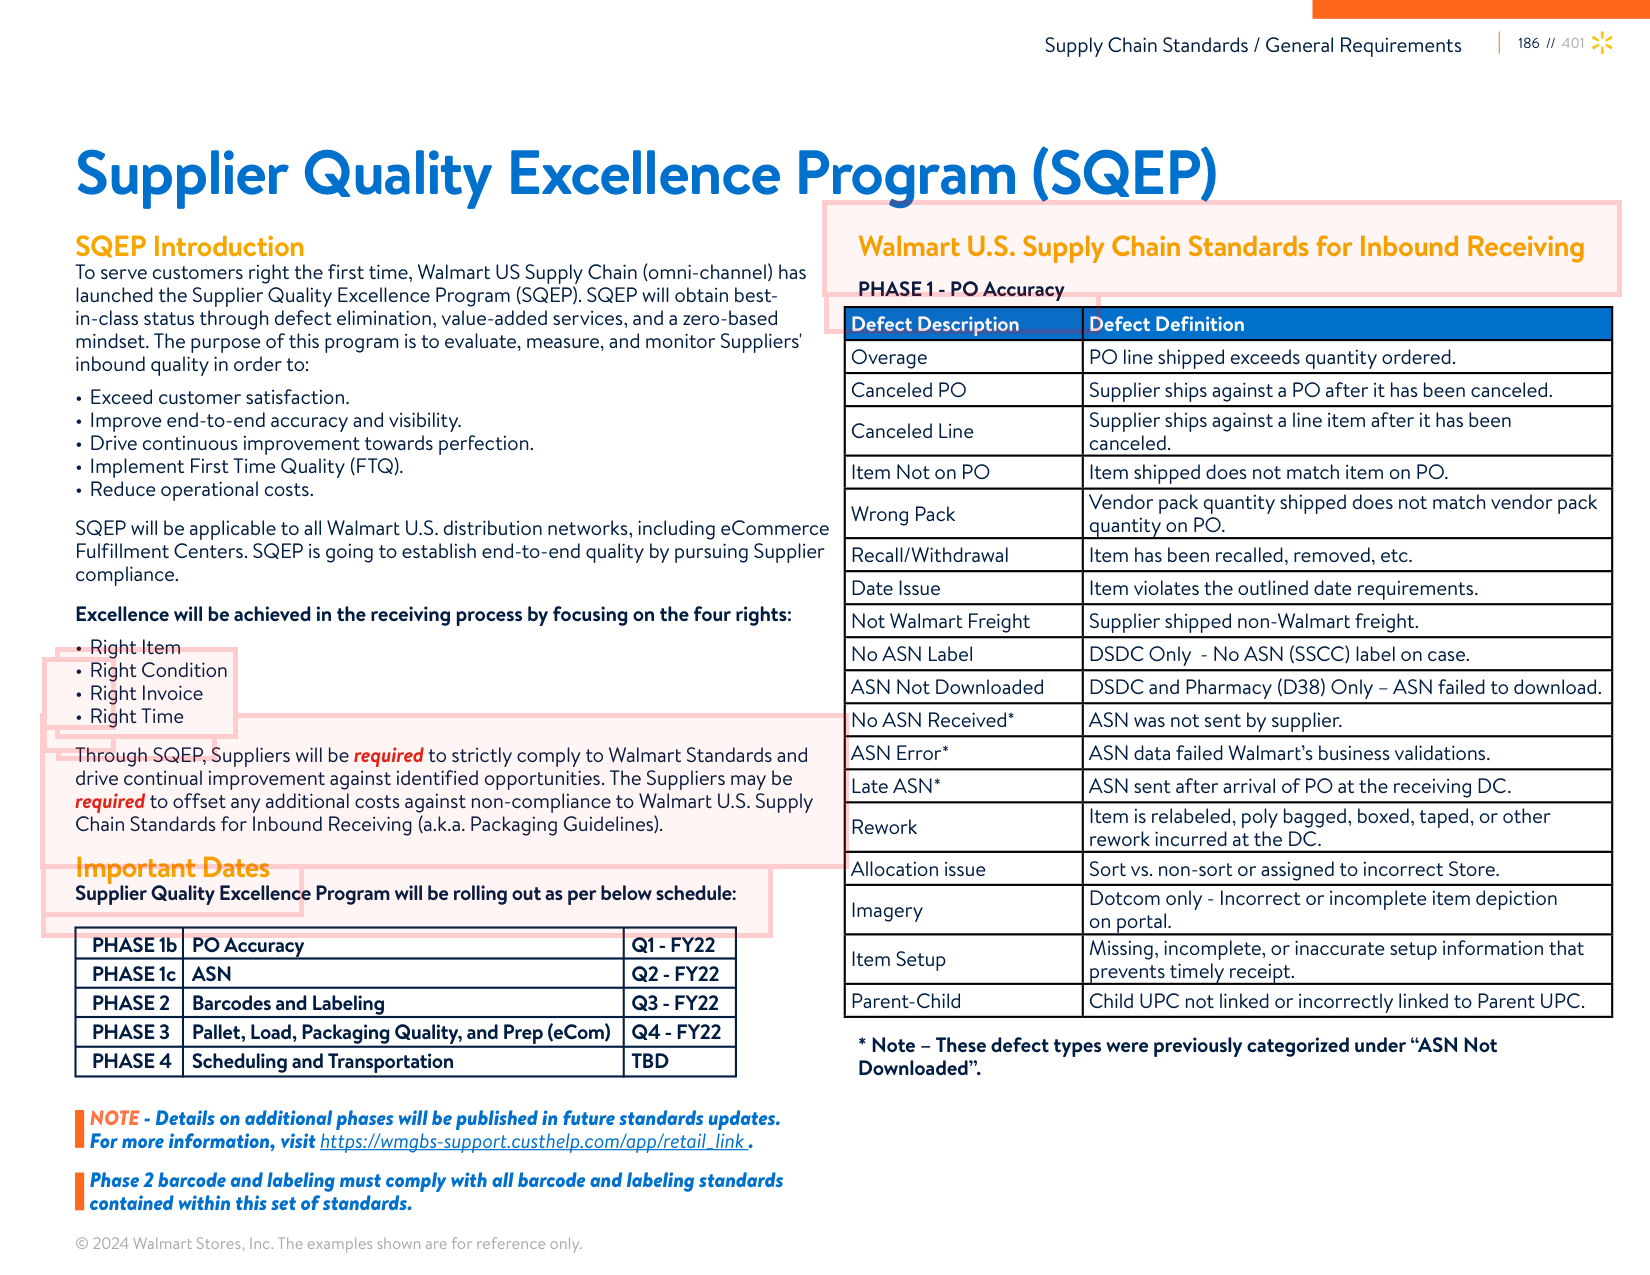

In [13]:
import fitz  # PyMuPDF
import requests
import hashlib
import os
from PIL import Image as PILImage, ImageDraw
from IPython.display import Image, display

import fitz  # PyMuPDF
import requests
import hashlib
import os
from PIL import Image as PILImage, ImageDraw
from IPython.display import Image, display

def render_page_of_pdf(url, page, bounding_boxes, render_dpi=150, padding=30):
    # Generate a unique filename based on the URL hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    pdf_filename = f"{url_hash}.pdf"

    # Download the PDF if it hasn't been saved locally yet
    if not os.path.exists(pdf_filename):
        response = requests.get(url)
        with open(pdf_filename, 'wb') as pdf_file:
            pdf_file.write(response.content)

    # Open the PDF
    doc = fitz.open(pdf_filename)

    # Check if the specified page exists
    if page < 1 or page > doc.page_count:
        print(f"Error: Page {page} does not exist in the PDF.")
        return

    # Render the page at the specified DPI
    pdf_page = doc.load_page(page - 1)  # PyMuPDF pages are zero-indexed
    scale_factor = render_dpi / 72
    render_matrix = fitz.Matrix(scale_factor, scale_factor)
    pix = pdf_page.get_pixmap(matrix=render_matrix)

    # Save the rendered page as an image
    output_image_path = "render.png"
    pix.save(output_image_path)

    # Open the image with Pillow and create a semi-transparent overlay
    img = PILImage.open(output_image_path)
    overlay = PILImage.new("RGBA", img.size, (255, 255, 255, 0))
    overlay_draw = ImageDraw.Draw(overlay)

    # Draw each bounding box in the list with opacity settings
    for bounding_box in bounding_boxes:
        top_left = (bounding_box['topLeftX'] - padding, bounding_box['topLeftY'] - padding)
        bottom_right = (bounding_box['bottomRightX'] + padding, bounding_box['bottomRightY'] + padding)

        olop = 50 if len(bounding_boxes) > 1 else 100
        fillop = 10 if len(bounding_boxes) > 1 else 50

        # Draw the filled rectangle with high opacity
        overlay_draw.rectangle([top_left, bottom_right], fill=(255, 0, 0, fillop))  # Red fill with 100/255 opacity

        # Draw the outline with lower opacity
        outline_width = 5
        for i in range(outline_width):
            overlay_draw.rectangle(
                [top_left[0] - i, top_left[1] - i, bottom_right[0] + i, bottom_right[1] + i],
                outline=(255, 0, 0, olop)  # Red outline with 200/255 opacity
            )

    # Composite the overlay onto the original image
    img = PILImage.alpha_composite(img.convert("RGBA"), overlay)

    # Save the image with bounding boxes overlay
    img = img.convert("RGB")  # Convert back to RGB before saving
    img.save(output_image_path)

page_data = qa_generation_data[2]

# Example usage:
render_page_of_pdf(
    url=page_data['documentUrl'],
    page=page_data['pageNumbers'][0],
    bounding_boxes=page_data['boundingBoxes']
)

# Display the image
display(Image(filename='render.png'))

# Creating a syncronous POC
The core components of QA pair generation with auditing visuals are there. Putting it all together to see how it looks.

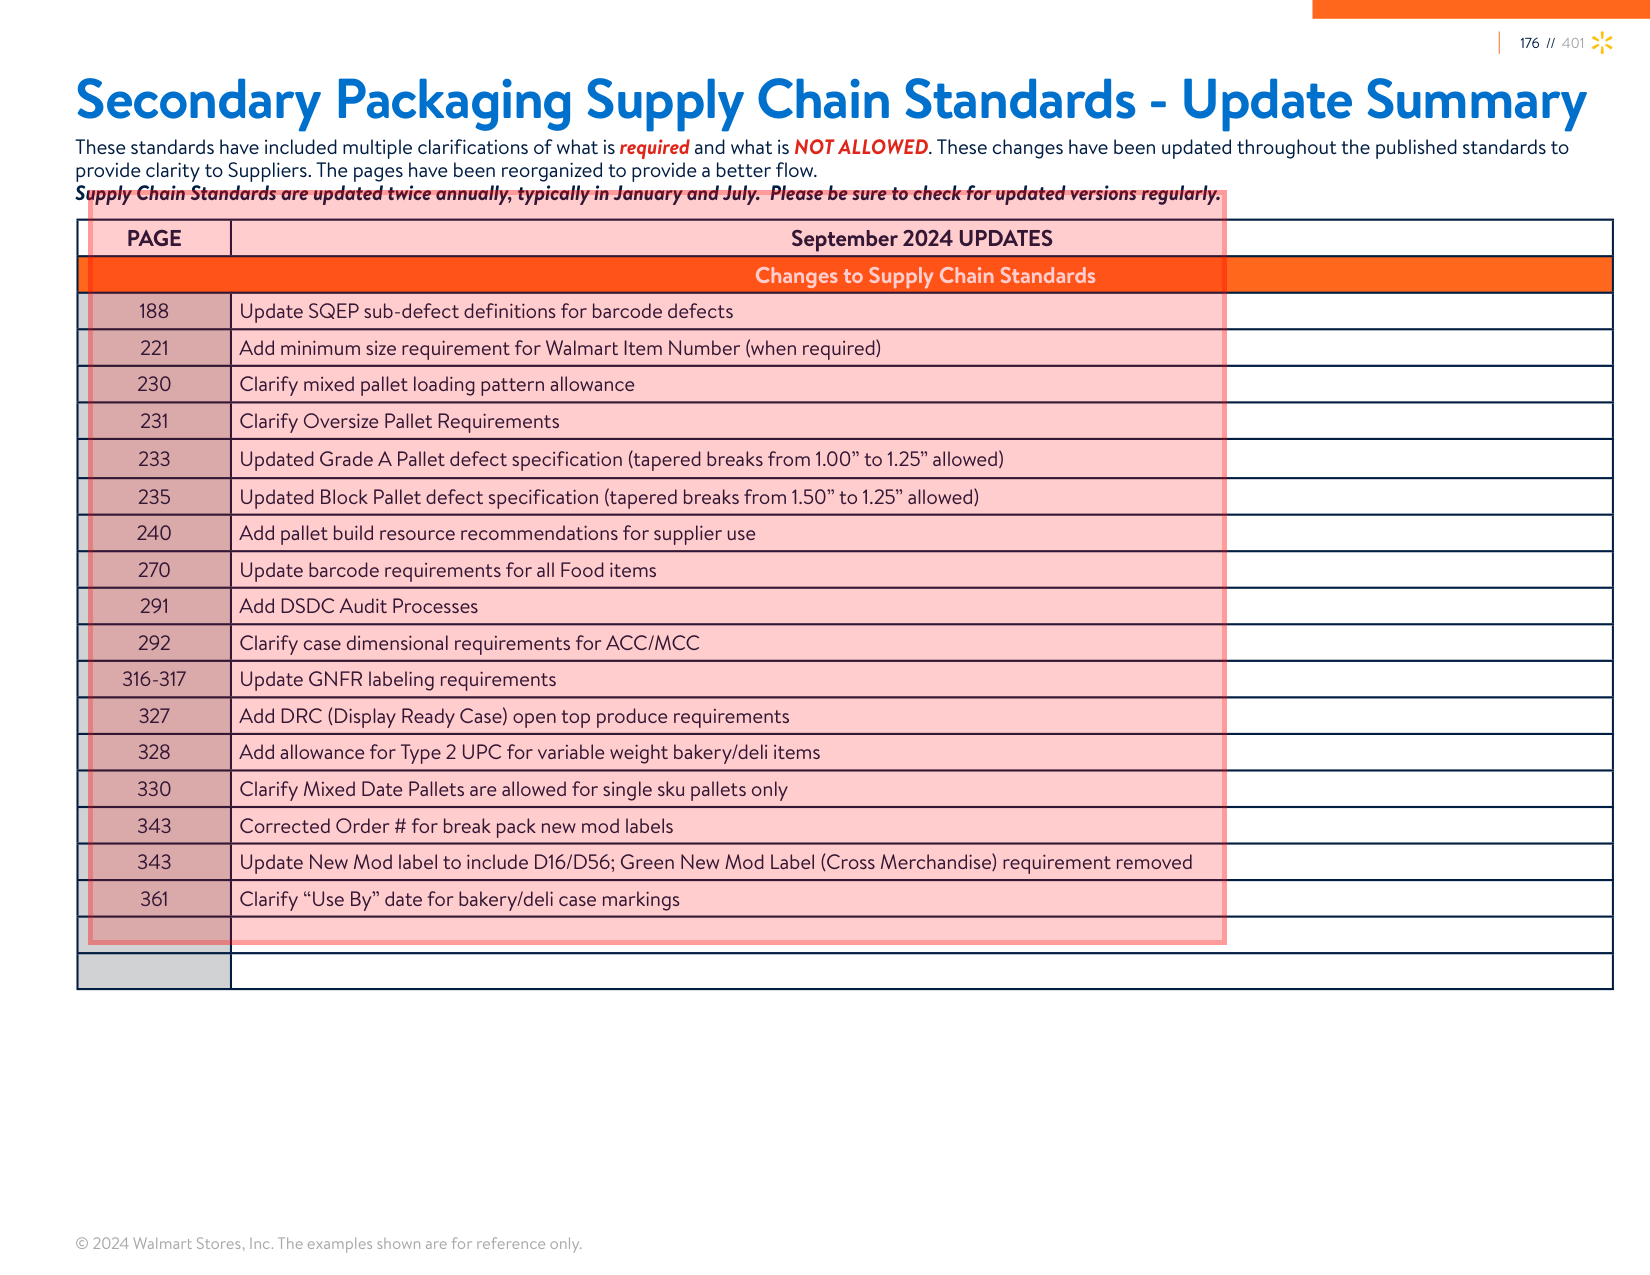

==== Rationale ====
The data provides a list of updates to Walmart's supply chain standards for September 2024, listed with specific page numbers associated with each update. Each entry specifies a change or clarification regarding operational requirements, including barcode requirements, pallet specifications, and labeling guidelines. An information extraction system might struggle with identifying which updates align with certain operational categories (e.g., barcodes, pallets), detecting the context of updates (e.g., whether they are clarifications or additions), and differentiating between types of updates that require compliance versus recommendations. Thus, the questions should focus on extracting specific updates related to designated topics in the provided document while ensuring clarity, precision, and prevent ambiguity in the answers.
=== question 0 ===
Question: What update is mentioned on page 188?
Answer: Update SQEP sub-defect definitions for barcode defects.
=== question

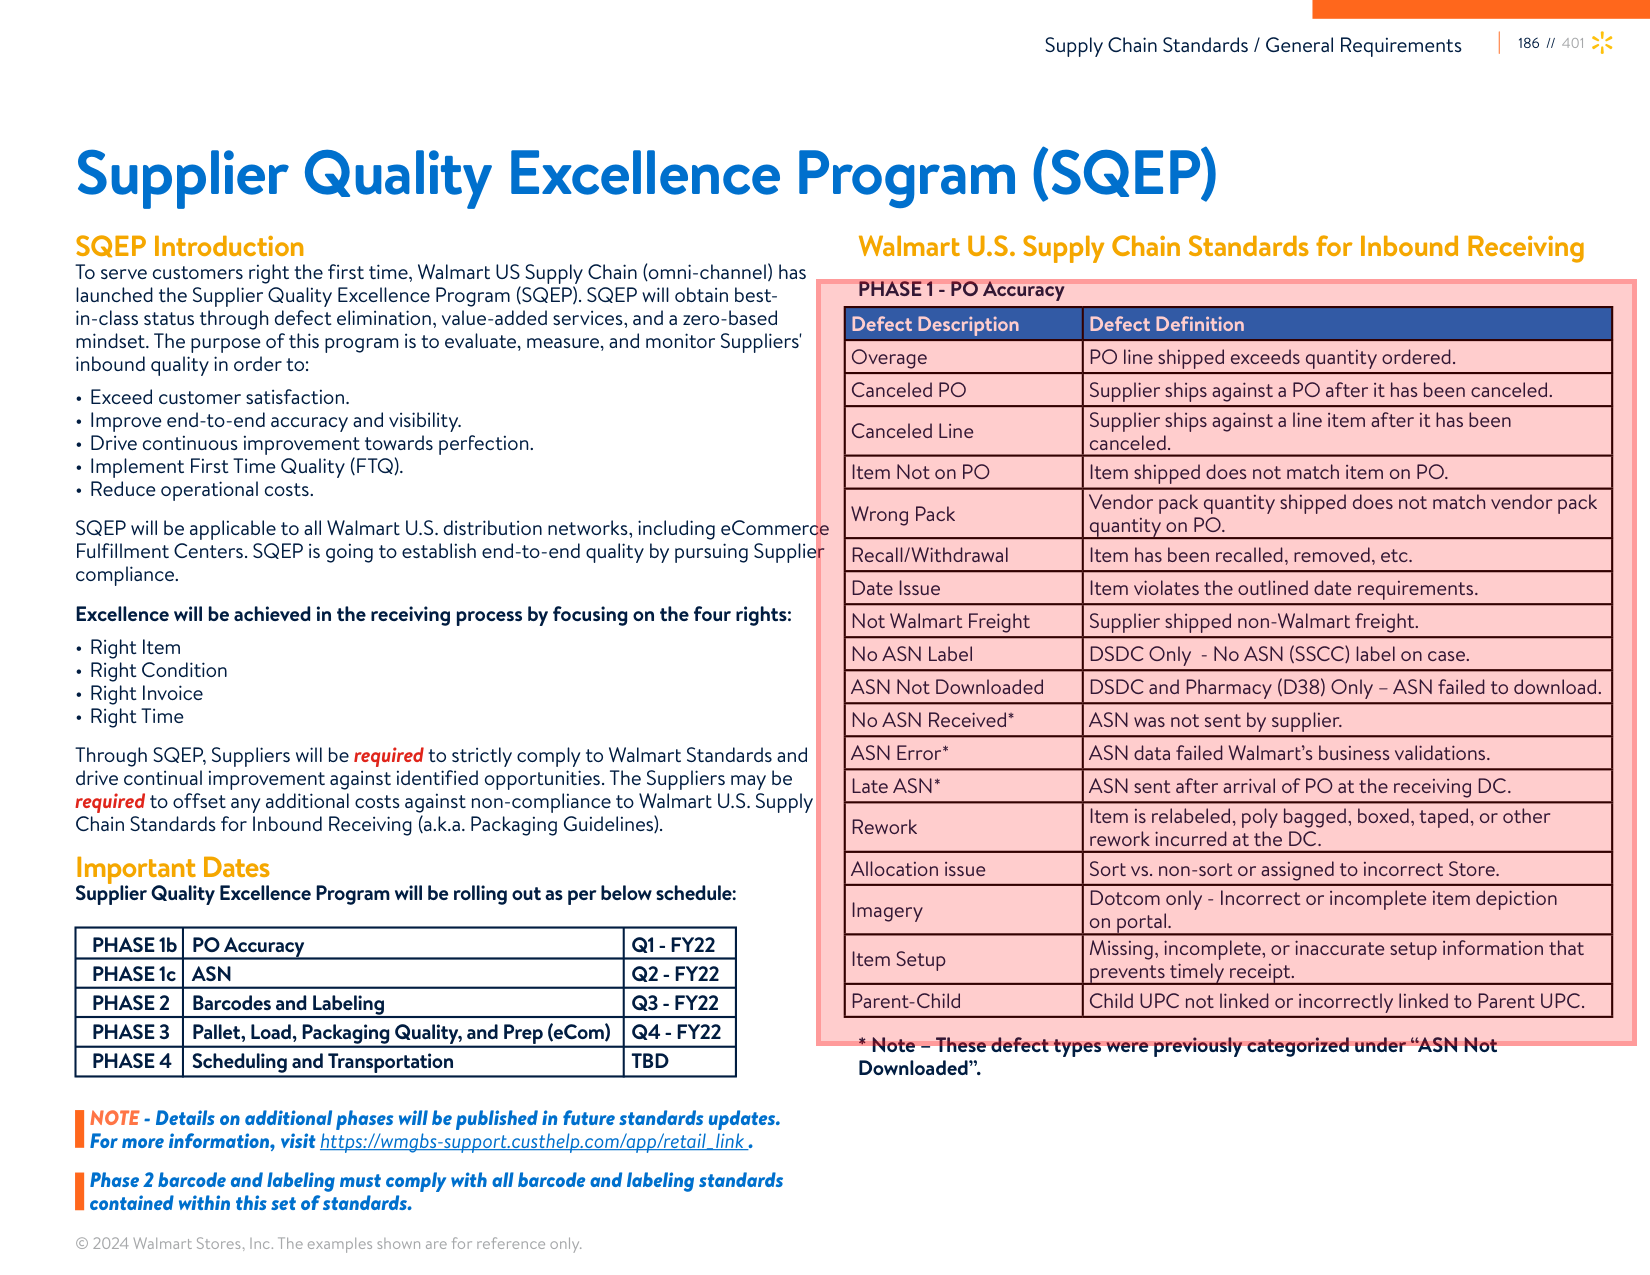

==== Rationale ====
The data provided outlines various defects related to shipping and supply chain processes for Walmart. Each defect description is paired with a specific definition that clarifies the nature of the defect. This information extraction task aims to assess the system's ability to identify and extract specific defect descriptions and their definitions accurately. Potential failures might include misinterpretation of the defect definitions, inability to correlate defect descriptions with their definitions, or confusion arising from similar defect terms.
=== question 0 ===
Question: What is the definition of 'Overage'?
Answer: PO line shipped exceeds quantity ordered.
=== question 1 ===
Question: What defect occurs when a supplier ships against a purchase order that has been canceled?
Answer: Canceled PO.
=== question 2 ===
Question: What does the defect 'Item Not on PO' mean?
Answer: Item shipped does not match item on PO.
=== question 3 ===
Question: What is indicated by

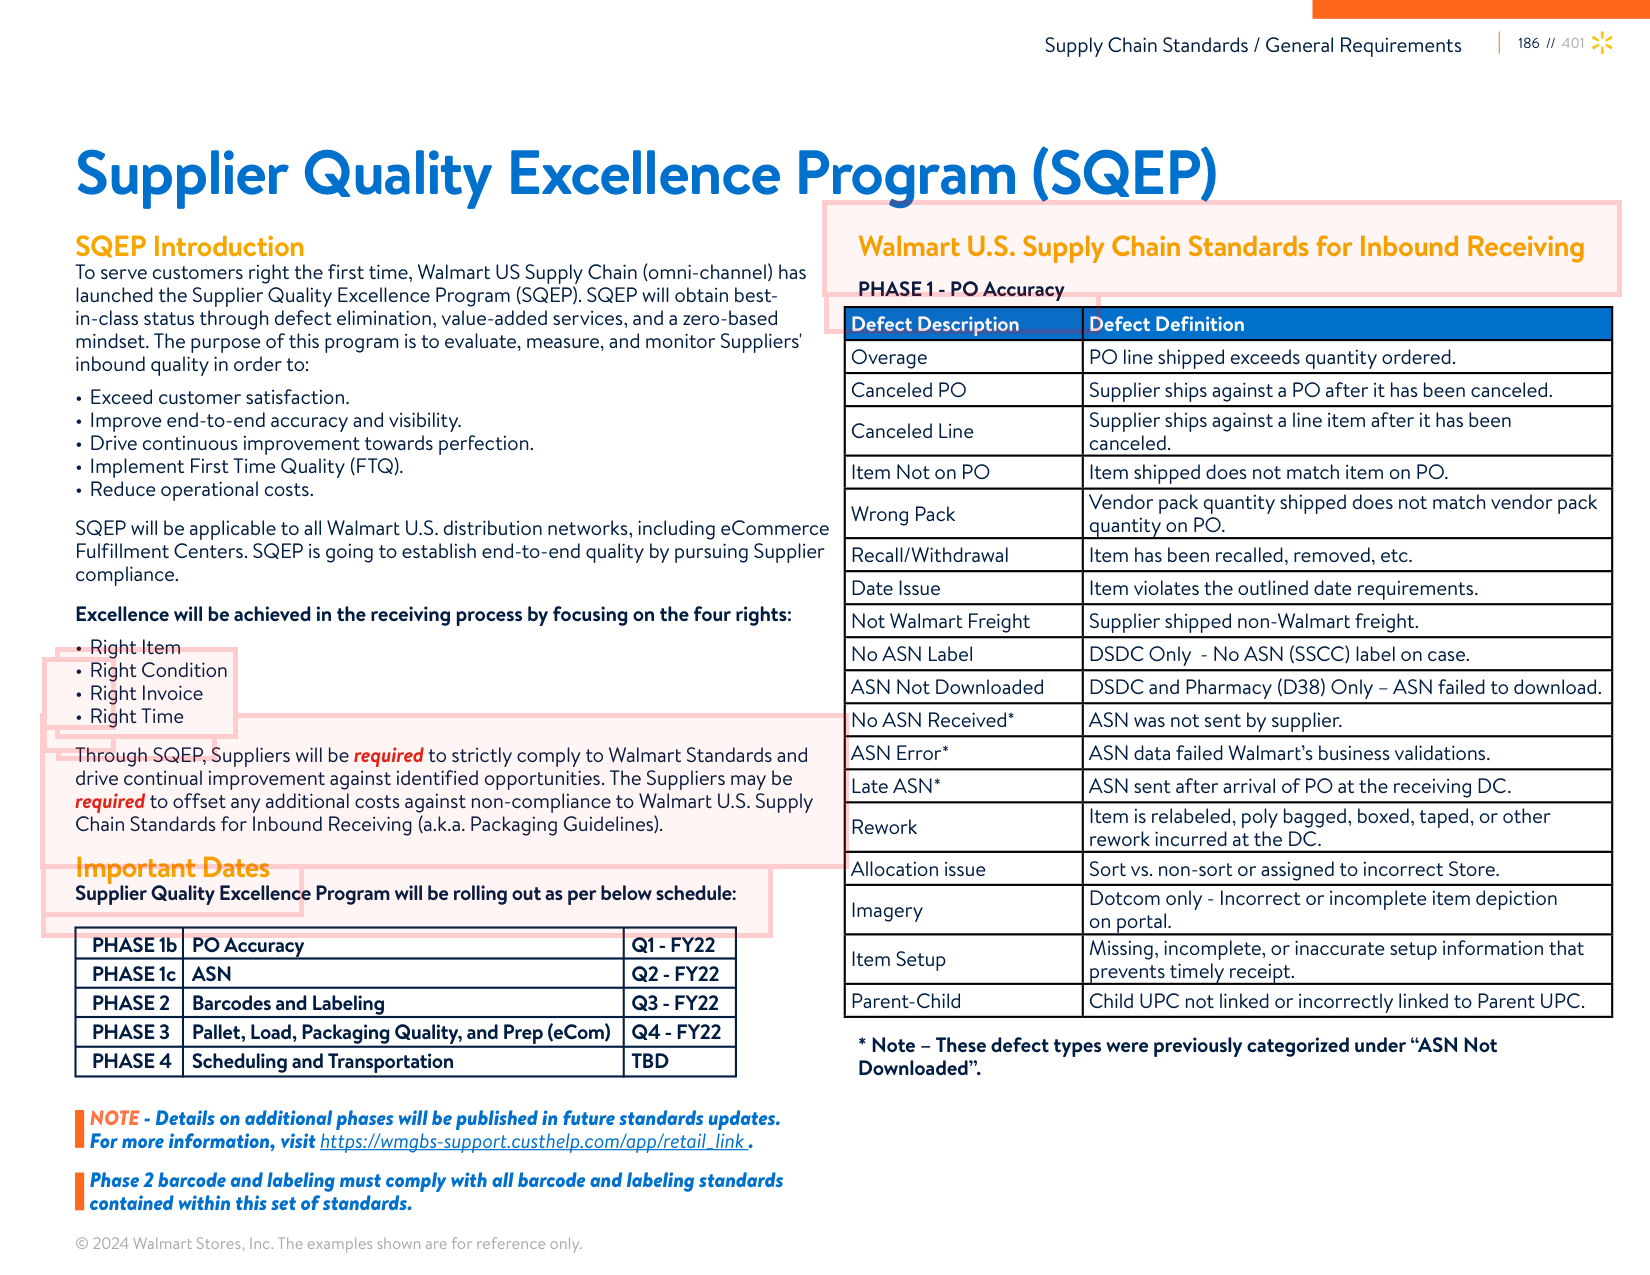

==== Rationale ====
The data provides information specific to Walmart's Supplier Quality Excellence Program (SQEP), outlining expectations for suppliers, standards compliance, and important dates. It includes specific requirements such as the 'Right Invoice' and 'Right Time', and mentions potential costs for non-compliance. An information extraction system might struggle to identify the specific phases and requirements clearly due to the use of phrases that imply broader quality measures without explicit categorization or timelines. Furthermore, it may confuse periods like 'PHASE 1' as vague rather than a concrete stage in a process unless explicitly addressed by questions.
=== question 0 ===
Question: What are the key requirements for suppliers participating in Walmart's Supplier Quality Excellence Program?
Answer: Suppliers must ensure the 'Right Invoice' and 'Right Time' in their operations, adhere to Walmart Standards, and continuously improve based on identified opportunities.
===

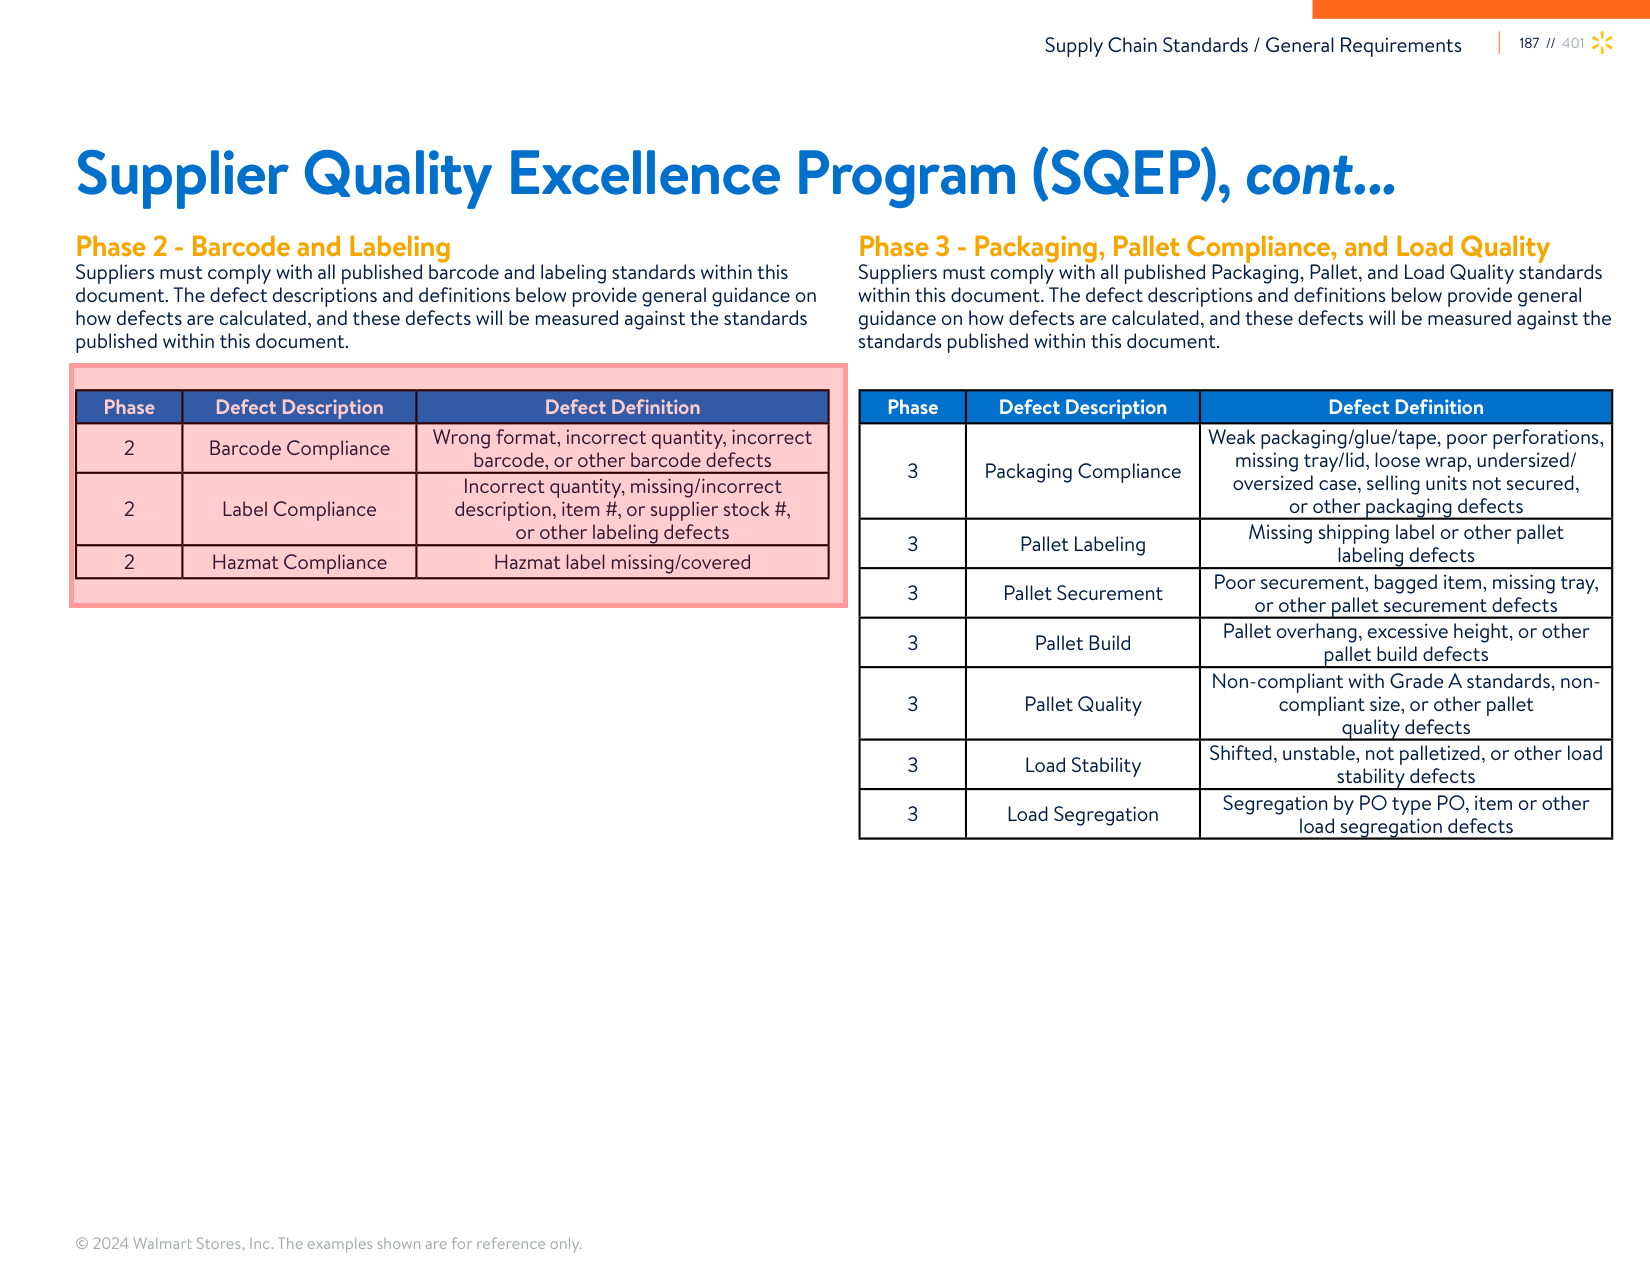

==== Rationale ====
The data provides information on various compliance defects categorized under Phase 2 of the Supplier Quality Excellence Program (SQEP) for Walmart. It includes specific types of defects such as Barcode Compliance, Label Compliance, and Hazmat Compliance, along with definitions that detail what constitutes these defects. An information extraction system may struggle to accurately categorize these defects or extract all necessary details if it does not recognize the specific terminology or if the definitions are too nuanced. Additionally, summarizing the compliance issues without understanding the context of SQEP could lead to incomplete information.
=== question 0 ===
Question: What is the defect description related to Barcode Compliance?
Answer: Barcode Compliance refers to wrong format, incorrect quantity, incorrect barcode, or other barcode defects.
=== question 1 ===
Question: What does Label Compliance signify in Phase 2?
Answer: Label Compliance signifies inco

In [14]:
batch_queue = []

for _, qa_gen_data in enumerate(qa_generation_data):
    #generate more batches if queue is low
    if len(batch_queue) < 3:
        batch_queue.append(gen_qa_batch(qa_gen_data))

    #popping 0th batch
    batch = batch_queue.pop(0)

    #rendering page and rationale, which is valid accross the batch
    render_page_of_pdf(
        url=batch['documentUrl'],
        page=batch['pageNumbers'][0],
        bounding_boxes=batch['boundingBoxes']
    )

    display(Image(filename='render.png'))

    print('==== Rationale ====')
    print(batch['rationale'])


    for i, qa in enumerate(batch['questions_answers']):
        print(f'=== question {i} ===')
        print(f'Question: {qa["question"]}')
        print(f'Answer: {qa["answer"]}')

        #TODO ability to edit question and answer.
        #ability to save question and answer, allong with all dat associated.
        #ability to discard question and answer
        #ability to skip to the next batch

    if _>2:
        break

# Creating Core Application
This uses functionality previously defined, wrapped in a multithreaded application. This allows the user to interact while Q/A pairs are generated on the fly in the background.

View the output cell full screen (the little box with the arrow at the top left of the output block) for slightly better ux.

When ready, run the next cell to see Q/A pairs.

**Note: The following only works in Google Colab (it uses some Colab specific tooling)**

In [17]:
import pandas as pd
from IPython.display import display, HTML, Javascript
import threading
import time
import os
import base64
from PIL import Image
from io import BytesIO

# Initialize a queue and DataFrame for storing accepted answers (no saving in this version)
batch_queue = []
current_question_index = 0  # Tracks the question within the current batch
accepted = []

# Background process to keep batch queue populated
def batch_generator():
    for _, qa_gen_data in enumerate(qa_generation_data):
        if len(batch_queue) < 20:
            batch_queue.append(gen_qa_batch(qa_gen_data))
        time.sleep(1)  # Adjustable sleep time

# Start the batch generator thread
batch_gen_thread = threading.Thread(target=batch_generator, daemon=True)
batch_gen_thread.start()

# Function to render the page of the document and save it as an image
def render_page(batch):
    render_page_of_pdf(
        url=batch['documentUrl'],
        page=batch['pageNumbers'][0],
        bounding_boxes=batch['boundingBoxes']
    )

    # Wait until render.png is fully created before proceeding
    while not os.path.exists("render.png"):
        time.sleep(0.1)

# Function to convert render.png to base64 format for embedding
def get_image_base64():
    with open("render.png", "rb") as image_file:
        image_data = image_file.read()
        image_base64 = base64.b64encode(image_data).decode('utf-8')
    return image_base64

# Enhanced HTML and JavaScript for UI with improved styling and no editing functionality
def render_ui(batch, qa_pair):
    # Render and show the document page
    render_page(batch)

    # Convert render.png to base64 for embedding
    image_base64 = get_image_base64()

    display(
        HTML(f"""
        <style>
            .container {{
                max-width: 700px;
                margin: 20px auto;
                padding: 20px;
                font-family: Arial, sans-serif;
                background-color: #ffffff;
                border: 1px solid #ddd;
                border-radius: 8px;
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            }}
            .image-container {{
                display: flex;
                justify-content: center;
                margin-bottom: 20px;
            }}
            .image-container img {{
                max-width: 100%;
                border-radius: 4px;
                border: 1px solid #ccc;
            }}
            .content {{
                text-align: left;
                color: #333;
            }}
            .content h3 {{
                color: #444;
            }}
            .actions {{
                text-align: center;
                margin-top: 20px;
            }}
            .actions button {{
                padding: 10px 15px;
                margin: 5px;
                background-color: #007BFF;
                color: white;
                border: none;
                border-radius: 4px;
                cursor: pointer;
            }}
            .actions button:hover {{
                background-color: #0056b3;
            }}
        </style>
        <div class="container">
            <div class="image-container">
                <img src="data:image/png;base64,{image_base64}" alt="Rendered Page">
            </div>
            <div class="content">
                <h3>Rationale</h3>
                <p>{batch['rationale']}</p>
                <h3>Question</h3>
                <p>{qa_pair['question']}</p>
                <h3>Answer</h3>
                <p>{qa_pair['answer']}</p>
            </div>
            <div class="actions">
                <button onclick="acceptQA()">Accept</button>
                <button onclick="skipQA()">Skip</button>
                <button onclick="skipBatch()">Skip Batch</button>
                <button onclick="stopEvaluation()">Stop</button>
            </div>
        </div>
        <script>
            function acceptQA() {{
                google.colab.kernel.invokeFunction('notebook.accept_qa', [], {{}});
            }}

            function skipQA() {{
                google.colab.kernel.invokeFunction('notebook.skip_qa', [], {{}});
            }}

            function skipBatch() {{
                google.colab.kernel.invokeFunction('notebook.skip_batch', [], {{}});
            }}

            function stopEvaluation() {{
                google.colab.kernel.invokeFunction('notebook.stop_evaluation', [], {{}});
            }}
        </script>
        """)
    )

# Callback functions for handling user actions
def accept_qa():
    accepted.append(batch_queue[0]['questions_answers'][current_question_index])
    skip_qa()

def skip_qa():
    global current_question_index
    batch = batch_queue[0]

    # Advance to the next question within the batch or move to the next batch if complete
    if current_question_index < len(batch['questions_answers']) - 1:
        current_question_index += 1
        display_next_qa()
    else:
        current_question_index = 0
        skip_batch()

def skip_batch():
    global current_question_index
    if batch_queue:
        batch_queue.pop(0)
    current_question_index = 0
    display_next_batch()

def stop_evaluation():
    print("Evaluation stopped.")

# Helper functions to update UI without clearing the entire cell
def display_next_qa():
    if batch_queue:
        batch = batch_queue[0]
        qa_pair = batch['questions_answers'][current_question_index]
        render_ui(batch, qa_pair)
    else:
        print("Waiting for new batches to be generated...")
        wait_for_batch()

def display_next_batch():
    display_next_qa()

def wait_for_batch():
    while not batch_queue:
        time.sleep(1)
    display_next_batch()

# Register the callback functions
from google.colab import output
output.register_callback('notebook.accept_qa', accept_qa)
output.register_callback('notebook.skip_qa', skip_qa)
output.register_callback('notebook.skip_batch', skip_batch)
output.register_callback('notebook.stop_evaluation', stop_evaluation)

# Display the first batch and QA pair
display_next_batch()

ModuleNotFoundError: No module named 'google'

In [24]:
accepted

[{'question': 'What update was made on page 188 of the September 2024 updates?',
  'answer': 'Update SQEP sub-defect definitions for barcode defects.'},
 {'question': 'What minimum size requirement was added for Walmart Item Number as per page 221?',
  'answer': 'Add minimum size requirement for Walmart Item Number (when required).'},
 {'question': 'Which update clarifies mixed pallet loading pattern allowance, and on what page can it be found?',
  'answer': 'Clarify mixed pallet loading pattern allowance is on page 230.'},
 {'question': "What is the definition of 'Overage'?",
  'answer': 'PO line shipped exceeds quantity ordered.'}]